In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import bartlett
import seaborn as sns
import scipy.stats as stats
# import shap
#Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#요일
def weekday(x):
    if x.dayofweek == 6:
        return '일'
    elif x.dayofweek == 0:
        return '월'
    elif x.dayofweek == 1:
        return '화'
    elif x.dayofweek == 2:
        return '수'
    elif x.dayofweek == 3:
        return '목'
    elif x.dayofweek == 4:
        return '금'
    else:
        return '토'

# 주말 여부
def weekend(x):
    if x.dayofweek in [5, 6]:
        return 1
    else: 
        return 0

In [3]:
# 기기별 일일 변수 합

def daysum_df(df) :
    temp = df.groupby(['device_id_deidentification','date']).sum()
    temp = pd.DataFrame(temp)
    return temp

In [4]:
# 기기별 일일 변수 평균

def daymean_df(df) :
    temp = df.groupby(['device_id_deidentification','date']).mean()
    temp = pd.DataFrame(temp)
    return temp

In [5]:
# 두 집단의 한 변수의 평균이 같은지 Test
def ttest(c1,c2,col_name):
    k = bartlett(c1[col_name],c2[col_name])[1] # 등분산검정
    if k < 0.05: # 두 그룹은 이분산성
        print(stats.ttest_ind(c1[col_name],c2[col_name],equal_var=False))
    else:
        print(stats.ttest_ind(c1[col_name],c2[col_name],equal_var=True))

In [6]:
def windstrength_equal(clusters):
    # 가장 자주 사용하는 windstrength mode가 smart user와 동일한가
    df1=pd.DataFrame(smart_dehum_user['airstate.windstrength'].value_counts()).sort_index()
    temp = []
    for c in clusters:
        df2=pd.DataFrame(c['airstate.windstrength'].value_counts()).sort_index()
        if int(df1.idxmax()) == int(df2.idxmax()):
            temp.append(c)
    clusters=temp
    return clusters

In [7]:
# funtion to find NoSmart dehum group
def ttest_find_NoSmart(clusters):
    NoSmart = []
    # 가장 자주 사용하는 windstrength mode가 smart user와 동일한가
    df1=pd.DataFrame(smart_dehum_user['airstate.windstrength'].value_counts()).sort_index()
    temp = []
    for c in clusters:
        df2=pd.DataFrame(c['airstate.windstrength'].value_counts()).sort_index()
        if int(df1.idxmax()) == int(df2.idxmax()):
            temp.append(c)
    clusters=temp

    for c in clusters:
        c1 = daysum_df(c)
        vt1 = bartlett(smart_dehum_user_daysum['energywatt'],c1['energywatt'])[1] # 등분산검정
        if vt1 < 0.05: # 두 그룹은 이분산성
            tvalue1 = stats.ttest_ind(c1['energywatt'],smart_dehum_user_daysum['energywatt'],equal_var=False)[0]
            pvalue1 = stats.ttest_ind(c1['energywatt'],smart_dehum_user_daysum['energywatt'],equal_var=False)[1]/2
        else:
            tvalue1 = stats.ttest_ind(c1['energywatt'],smart_dehum_user_daysum['energywatt'],equal_var=True)[0]
            pvalue1 = stats.ttest_ind(c1['energywatt'],smart_dehum_user_daysum['energywatt'],equal_var=True)[1]/2
        # 일일 에너지소모량 합의 평균이 스마트 그룹보다 큰가
        if (pvalue1 < 0.05) & (tvalue1 > 0): # 즉 앞의 그룹의 평균이 더 큼
            vt2 = bartlett(smart_dehum_user['humidity'],c['humidity'])[1] # 등분산검정
            if vt2 < 0.05: # 두 그룹은 이분산성
                tvalue2 = stats.ttest_ind(c['humidity'],smart_dehum_user['humidity'],equal_var=False)[0]
                pvalue2 = stats.ttest_ind(c['humidity'],smart_dehum_user['humidity'],equal_var=False)[1]/2
            else:
                tvalue2 = stats.ttest_ind(c['humidity'],smart_dehum_user['humidity'],equal_var=True)[0]
                pvalue2 = stats.ttest_ind(c['humidity'],smart_dehum_user['humidity'],equal_var=True)[1]/2
            # 시간별 습도의 평균이 스마트 그룹보다 큰가
            if (pvalue2 < 0.05) & (tvalue2 > 0): # 두 조건모두 스마트 그룹보다 클때
                NoSmart.append(c)
            else: continue
        else: continue
    return NoSmart

In [8]:
def compare_smart_boxplot_energysum(Clid_Num): # boxplot으로 일일 에너지 소모량을 스마트 유저와 비교
    temp = all_df.loc[all_df.Clid==Clid_Num]
    temp2 = daysum_df(temp)

    plt.boxplot([temp2['energywatt'],smart_dehum_user_daysum['energywatt']])
    temp2_q2 = np.percentile(temp2['energywatt'],50)
    smart_q2 = np.percentile(smart_dehum_user_daysum['energywatt'],50)

    plt.text(1.1, temp2_q2, temp2_q2)
    plt.text(2.1, smart_q2, smart_q2)

    plt.xticks([1,2],[f'Clid_{Clid_Num}','Smart_User'])
    
    plt.show()

In [9]:
def compare_smart_boxplot_humidity(Clid_Num): # boxplot으로 습도을 스마트 유저와 비교
    temp = all_df.loc[all_df.Clid==Clid_Num]

    plt.boxplot([temp['humidity'],smart_dehum_user['humidity']])
    temp_q2 = np.percentile(temp['humidity'],50)
    smart_q2 = np.percentile(smart_dehum_user['humidity'],50)

    plt.text(1.1, temp_q2, temp_q2)
    plt.text(2.1, smart_q2, smart_q2)

    plt.xticks([1,2],[f'Clid_{Clid_Num}','Smart_User'])
    
    plt.show()

In [10]:
# 시계열 분해 시각화
def vis_time_series_decompose(df,col_name):
    df=df.set_index(['create_dt'])
    df = df.resample('H').mean()
    df = df.interpolate(method='linear')
    res = sm.tsa.seasonal_decompose(df[col_name], model='additive')

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
    res.observed.plot(ax=ax1, title='Observed')
    res.trend.plot(ax=ax2, title='Trend')
    res.resid.plot(ax=ax3, title='Residual')
    res.seasonal.plot(ax=ax4, title='Seasonal')
    plt.tight_layout()
    plt.show()

In [11]:
all_df = pd.read_csv('all_data.csv')
dep_genes = pd.read_csv('DEP_genes.dat',sep='\t') # 클러스터 info

all_df = pd.merge(all_df,dep_genes,left_on='device_id_deidentification',right_on='GeneID',how='left')
all_df.dropna(subset=['Type'],inplace=True)

all_df['device_id_deidentification']=all_df['device_id_deidentification'].str[8:]
all_df['Clid'] = all_df['Clid'].astype(int)
all_df['create_dt'] = pd.to_datetime(all_df['create_dt']) # datetime으로 변경
all_df = all_df.drop(['GeneID', 'Type','airstate.miscfuncstate.uvnano','airstate.miscfuncstate.filtercleanauto'], axis=1) # 필요없는 칼럼 삭제

In [12]:
# create_dt 월 일 시간 주말 평일로 변환
all_df['month'] = all_df['create_dt'].dt.month
all_df['day'] = all_df['create_dt'].dt.day
all_df['hour'] = all_df['create_dt'].dt.hour
all_df['minute'] = all_df['create_dt'].dt.minute
all_df['weekday'] = all_df['create_dt'].apply(weekday)
all_df['weekend'] = all_df['create_dt'].apply(weekend)
all_df['date'] = all_df['create_dt'].dt.date

In [13]:
# 체감온도 변수 생성
all_df['sensory_temp']=13.12+0.6215*all_df['currenttemperature']-13.947*all_df['airstate.windstrength']**0.16+0.486*all_df['currenttemperature']*all_df['airstate.windstrength']**0.16

In [14]:
# 제습모드를 잘 활용하고 있는 군집
smart_dehum_user = all_df.loc[all_df['Clid'].isin([1,7,14])]
# 제습모드를 항상켜놓고 있는 군집
always_dehum_user = all_df.loc[all_df['Clid'].isin([5,6])]
# 제습모드를 잘 사용 못하는 군집
not_dehum_user = all_df.loc[all_df['Clid'].isin([11])]

In [15]:
# 일일 사용량합 df
all_df_daysum = daysum_df(all_df)
smart_dehum_user_daysum = daysum_df(smart_dehum_user)
always_dehum_user_daysum = daysum_df(always_dehum_user)
not_dehum_user_daysum = daysum_df(not_dehum_user)

/tmp/ipykernel_2529/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()
/tmp/ipykernel_2529/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()
/tmp/ipykernel_2529/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','dat

In [16]:
smart_dehum_user_daysum

airstate.opmode  \
device_id_deidentification                         date                          
0031970b9f5ead744c0fa6b6c2e37d63d7d61e9268314a3... 2021-07-08              103   
                                                   2021-07-09              107   
0161d2c07afb9b963d0ff0c0f81a0b5ed2e681ba9be3296... 2021-07-21               22   
                                                   2021-07-22               97   
                                                   2021-07-24              135   
...                                                                        ...   
fe957538d1ff3113d02f2f9f3fd3058970fbcc8a872a260... 2021-07-18              108   
                                                   2021-07-26               25   
                                                   2021-07-27               57   
ffeaac61437d52a2f3d527ea5c1a642302a9b45a2353405... 2021-07-17              120   
                                                   2021-07-18              108   

                                                               energywatt  \
device_id_deidentification                         date                     
0031970b9f5ead744c0fa6b6c2e37d63d7d61e9268314a3... 2021-07-08        4562   
                                                   2021-07-09         569   
0161d2c07afb9b963d0ff0c0f81a0b5ed2e681ba9be3296... 2021-07-21        7813   
                                                   2021-07-22        1621   
                                                   2021-07-24        5531   
...                                                                   ...   
fe957538d1ff3113d02f2f9f3fd3058970fbcc8a872a260... 2021-07-18        2779   
                                                   2021-07-26        4990   
                                                   2021-07-27        2756   
ffeaac61437d52a2f3d527ea5c1a642302a9b45a2353405... 2021-07-17        5205   
                                                   2021-07-18        1756   

                                                               humidity  \
device_id_deidentification                         date                   
0031970b9f5ead744c0fa6b6c2e37d63d7d61e9268314a3... 2021-07-08   12138.0   
                                                   2021-07-09    8155.0   
0161d2c07afb9b963d0ff0c0f81a0b5ed2e681ba9be3296... 2021-07-21   10591.0   
                                                   2021-07-22    7199.0   
                                                   2021-07-24   11779.0   
...                                                                 ...   
fe957538d1ff3113d02f2f9f3fd3058970fbcc8a872a260... 2021-07-18    6853.0   
                                                   2021-07-26   11118.0   
                                                   2021-07-27    6396.0   
ffeaac61437d52a2f3d527ea5c1a642302a9b45a2353405... 2021-07-17   12502.0   
                                                   2021-07-18    8128.0   

                                                               airstate.windstrength  \
device_id_deidentification                         date                                
0031970b9f5ead744c0fa6b6c2e37d63d7d61e9268314a3... 2021-07-08                    102   
                                                   2021-07-09                    107   
0161d2c07afb9b963d0ff0c0f81a0b5ed2e681ba9be3296... 2021-07-21                    174   
                                                   2021-07-22                    107   
                                                   2021-07-24                    180   
...                                                                              ...   
fe957538d1ff3113d02f2f9f3fd3058970fbcc8a872a260... 2021-07-18                      0   
                                                   2021-07-26                    169   
                                                   2021-07-27                     46   
ffeaac61437d52a2f3d527ea5c1a642302a9b45a2353405...

In [17]:
# 제습모드를 24시간 사용하는 기기의 7월 한 달내 일 사용횟수 카운팅 
device = always_dehum_user['device_id_deidentification'].unique()

always_25_device = []
all_count = []
for db in device:
    count = always_dehum_user.loc[always_dehum_user.device_id_deidentification==db]['date'].nunique()
    all_count.append(count)   
    if count > 25:
         always_25_device.append(db)
    else: continue

mean : 6.6020408163265305
max : 29
min : 2


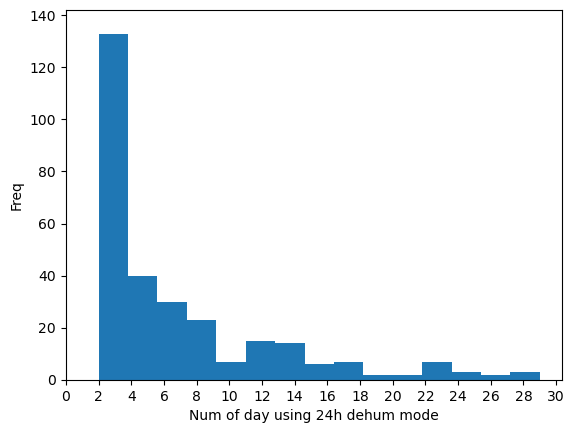

In [18]:
all_count=np.array(all_count)
print(f"mean : {all_count.mean()}")
print(f"max : {all_count.max()}")
print(f"min : {all_count.min()}")

plt.hist(all_count,bins=15)
plt.xticks(np.arange(0,31,2))
plt.ylim(0,142)
plt.xlabel("Num of day using 24h dehum mode")
plt.ylabel("Freq")
# plt.savefig("24h_dehum_mode_hist.png",dpi=600)
plt.show()

In [21]:
weather = pd.read_csv('daily_weather.csv')
weather.rename(columns = {'Unnamed: 0' : 'date'}, inplace = True)
weather['date'] = pd.to_datetime(weather['date'])
weather

,date,최고체감온도(°C),최고기온(°C),평균기온(°C),최저기온(°C),평균상대습도(%),강수량(mm)
0,2021-07-01,31.203727,30.930864,24.702484,19.203086,75.592500,0.4
1,2021-07-02,30.654037,30.093789,24.667081,20.309317,74.710063,0.3
2,2021-07-03,27.427329,25.430625,22.426875,20.256250,85.918354,41.4
3,2021-07-04,28.640373,26.100617,23.053086,20.658025,88.188125,19.4
4,2021-07-05,27.920497,25.724074,22.407407,19.875309,87.353125,26.0
5,2021-07-06,29.159006,26.830435,23.540994,20.627329,89.940252,51.6
6,2021-07-07,30.434161,27.804938,24.722222,22.291975,91.649375,33.7
7,2021-07-08,31.183230,29.276543,24.878395,22.264815,88.275625,23.2
8,2021-07-09,30.898137,29.175926,24.785185,22.079012,85.885000,6.8
9,2021-07-10,31.457764,29.940123,24.977019,21.803106,85.297484,6.5


In [29]:
df = always_dehum_user_daysum.reset_index()
df['date']=pd.to_datetime(df['date'])
date_df=pd.DataFrame(df['date'].value_counts())
date_df.reset_index(inplace=True)
date_df.columns = ['date','count']
date_df= date_df.sort_values(by='date')
# date_df.reset_index(inplace=True)
date_df = pd.merge(date_df,weather,how='left',on='date')

/tmp/ipykernel_2529/1479187237.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


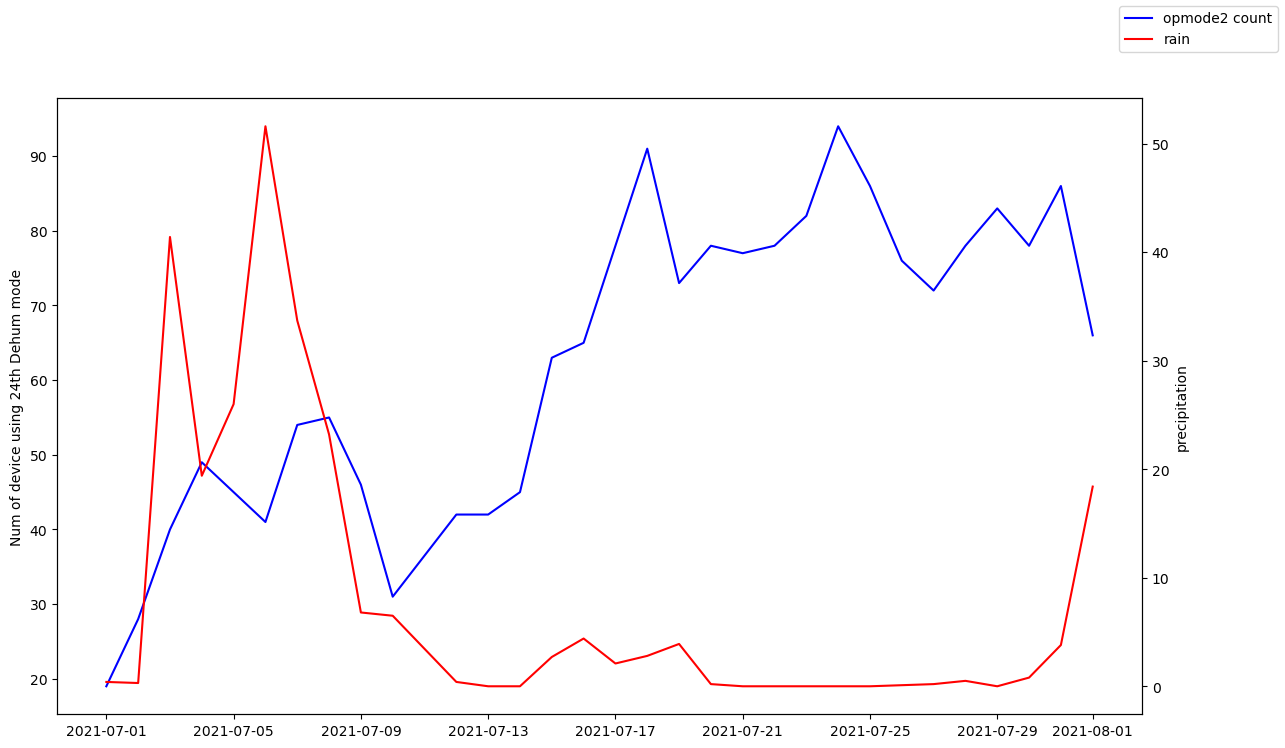

In [57]:
fig,ax = plt.subplots(1,1,figsize=(14,8))
ax.plot('date','count',data=date_df,label='opmode2 count',color='b')
ax.set_ylabel('Num of device using 24th Dehum mode')

ax2 = ax.twinx()
ax2.plot('date','강수량(mm)',data=date_df,label='rain',color='r')
ax2.set_ylabel('precipitation')
# plt.ylim(10,100)

# plt.savefig("24h_dehum_mode_plot.png",dpi=600)
fig.legend()
# ax2.legend()
fig.show()

(array([5.410e+02, 1.319e+03, 2.880e+02, 5.700e+01, 1.600e+01, 7.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([    0.        ,  4377.22592593,  8754.45185185, 13131.67777778,
        17508.9037037 , 21886.12962963, 26263.35555556, 30640.58148148,
        35017.80740741, 39395.03333333, 43772.25925926]),
 <BarContainer object of 10 artists>)

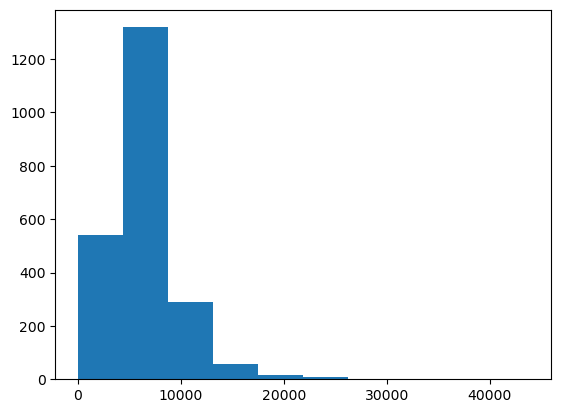

In [19]:
# 기기별 일일 평균 에너지 사용량
plt.hist(all_df_daysum.groupby('device_id_deidentification')['energywatt'].mean())

In [20]:
# 기기별 일일 평균 에너지 사용량
all_df.groupby('Clid')['device_id_deidentification'].unique()

Clid
1     [1bdbf6c82768fa0921c7fe0f923275d2fe73731be62a6...
2     [08f45a1dfc6a22f00e48709f6bc30cc82248799ba45fa...
3     [2cb01fbac5b6de472153baa02dd1b094948db122a6042...
4     [7bed2351b247583d412983e8d9ad0a244318f6a2d9807...
5     [09cc46c8d200f97efd8b030d241e41580bf7171245bdc...
6     [0559f6413b42477a1dc96f95b8db6e1f070a3e06b245f...
7     [8a297a42c7dba7c334cefe4c242aaec769f6c1599b09c...
8     [018c950c0b22cfb5eb46949a78bdfd1464851d74b3904...
9     [02b801d2aac3c685fc76983a93899c18fe3e9e7e9628c...
10    [21a3cf0493c5feb0ad41e0a6af7508cb79b15ff4df177...
11    [10cdd7d24e9dc5b58e4fdd416d45c774d8a599a33afe9...
12    [07afed98d25d00a7bdce899f9d9c619cb56cac2504aa7...
13    [012edf79cb910515ce3629058263e5dc2b43a77c234f5...
14    [4165e2e8041a4cd65f26bd83882635886fdec691bbb3f...
15    [12e4e31d20b8c808b070391dc9117305833483b532a7f...
16    [14484695ce059aecb425f199a9688ba28d79937e8114a...
Name: device_id_deidentification, dtype: object

In [21]:
all_df['Clid'].value_counts() # 전체 클러스터 수

9     599801
12    579418
8     458910
10    353630
3     297424
11    255206
2     211906
5     200437
6     176079
15    145928
4      73414
13     72763
16     57456
7      49192
1      41536
14     28354
Name: Clid, dtype: int64

In [22]:
# 클러스터별 기기 사용 횟수
cluster_use_count=pd.DataFrame(all_df.groupby('Clid')['device_id_deidentification'].value_counts())

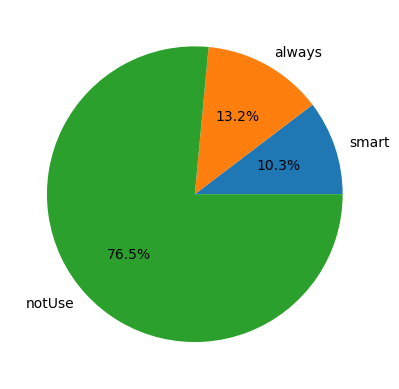

In [23]:
# 클러스터별 기기 갯수
cluster_smart = len(smart_dehum_user['device_id_deidentification'].unique())
cluster_always = len(always_dehum_user['device_id_deidentification'].unique())
cluster_not = len(all_df['device_id_deidentification'].unique()) - (cluster_smart+cluster_always)
cluster_num=[cluster_smart,cluster_always,cluster_not]

labels = ['smart','always','notUse']

plt.pie(cluster_num,labels=labels,autopct='%.1f%%')
plt.show()

In [24]:
# 231개의 기기
len(smart_dehum_user['device_id_deidentification'].unique())

231

In [25]:
# 기기별 제습모드 활용 빈도 체크
opmode2_smart=smart_dehum_user.groupby('device_id_deidentification').agg({'airstate.opmode2':'count'})

(array([139.,  52.,  17.,   8.,   1.,   7.,   2.,   3.,   1.,   1.]),
 array([ 280. ,  509.2,  738.4,  967.6, 1196.8, 1426. , 1655.2, 1884.4,
        2113.6, 2342.8, 2572. ]),
 <BarContainer object of 10 artists>)

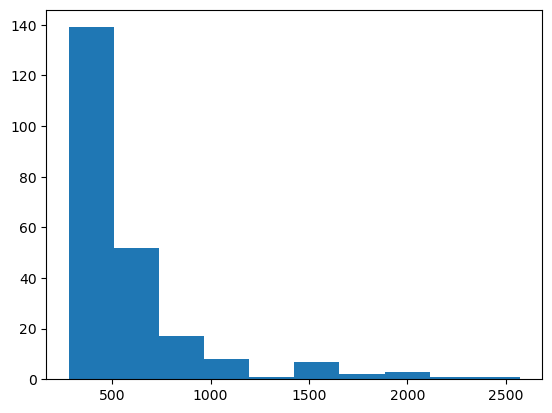

In [26]:
plt.hist(opmode2_smart)

In [28]:
# 294개의 기기
len(always_dehum_user['device_id_deidentification'].unique())

294

(array([178.,  45.,  18.,  21.,   8.,   9.,   2.,   8.,   0.,   5.]),
 array([ 280. ,  969.2, 1658.4, 2347.6, 3036.8, 3726. , 4415.2, 5104.4,
        5793.6, 6482.8, 7172. ]),
 <BarContainer object of 10 artists>)

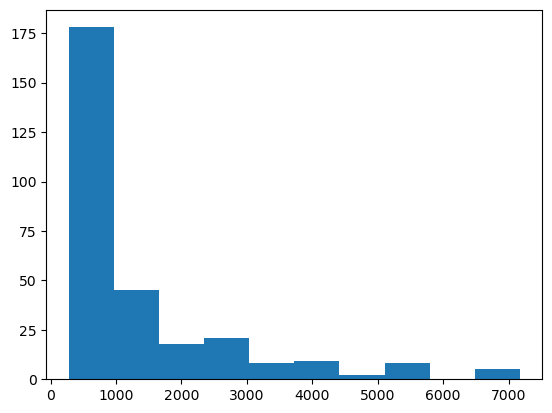

In [29]:
opmode2_always=always_dehum_user.groupby('device_id_deidentification').agg({'airstate.opmode2':'count'})
plt.hist(opmode2_always)

In [29]:
smart_dehum_user_daysum.corr()['energywatt']

airstate.opmode              0.250488
energywatt                   1.000000
humidity                     0.424535
airstate.windstrength        0.287598
currenttemperature           0.509750
airstate.tempstate.target    0.437835
pm1                         -0.022559
pm2                         -0.022246
pm10                        -0.021602
airstate.opmode2             0.257694
Clid                         0.231671
month                        0.546790
day                          0.467405
hour                         0.545202
minute                       0.547352
weekend                      0.093912
sensory_temp                 0.520860
Name: energywatt, dtype: float64

In [41]:
corr = []
df_lst = [smart_dehum_user_daysum,always_dehum_user_daysum,all_df_daysum]
for df in df_lst: 
    num_corr = df.corr()['energywatt'] # 전력 사용량 일 평균 합으로 하고 나머지 도 합으로 한다음 다른 df로 적용해봐야함
    num_corr = num_corr.drop(['Clid','energywatt','month','day','hour','minute','currenttemperature'])
    corr.append(num_corr)
corr_df = pd.concat(corr,axis=1).T
corr_df.index = ['smart','always','all']

# # 시각화
# ax = plt.subplots(figsize=(20,8))
# sns.heatmap(corr_df.T,cmap=sns.diverging_palette(240,10,as_cmap=True), ax=ax)
# plt.show()

In [42]:
corr_df

,airstate.opmode,humidity,airstate.windstrength,airstate.tempstate.target,pm1,pm2,pm10,airstate.opmode2,weekend,sensory_temp
smart,0.250488,0.424535,0.287598,0.437835,-0.022559,-0.022246,-0.021602,0.257694,0.093912,0.520860
always,0.039117,0.457669,0.324018,0.546336,0.003852,0.006814,0.005978,0.591411,0.122660,0.583123
all,0.393804,0.430664,0.324233,0.488521,0.001631,-0.001392,-0.001972,0.089483,0.109263,0.530292


In [43]:
clusters = []
c = [2,3,4,8,9,10,11,12,13,15,16]
for i in c:
    temp = all_df.loc[all_df.Clid==i]
#     temp = daysum_df(temp)
#     temp.reset_index(inplace=True)
    clusters.append(temp)
NoSmart = ttest_find_NoSmart(clusters)

final_cluster = []

for i in range(len(NoSmart)): 
    c=NoSmart[i].iloc[0,12]
    final_cluster.append(c)

final_cluster # 최종 NOSMART 그룹의 클러스터 인덱스 확인

print(f"NoSmart 그룹 개수 : {len(NoSmart)}")
print(f"NoSmart 그룹 = {final_cluster}")

/tmp/ipykernel_3353/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()
/tmp/ipykernel_3353/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()
/tmp/ipykernel_3353/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','dat

NoSmart 그룹 개수 : 1
NoSmart 그룹 = [11]


/tmp/ipykernel_3353/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()
/tmp/ipykernel_3353/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()
/tmp/ipykernel_3353/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','dat

In [44]:
# always dehum user도 active 유저와 자주 사용하는 바람세기 모드가 동일한 지 확인
clusters = []
c = [5,6]
for i in c:
    temp = all_df.loc[all_df.Clid==i]
    clusters.append(temp)
dd = windstrength_equal(clusters)
len(dd) # 동일하다

2

In [45]:
clid=all_df[['device_id_deidentification','Clid']]
# clid=clid.drop_duplicates()

/tmp/ipykernel_3353/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()


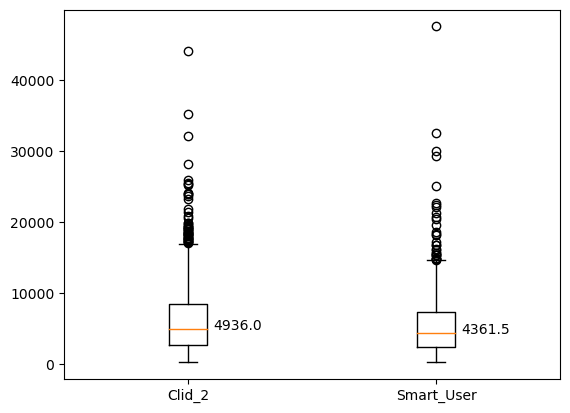

/tmp/ipykernel_3353/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()


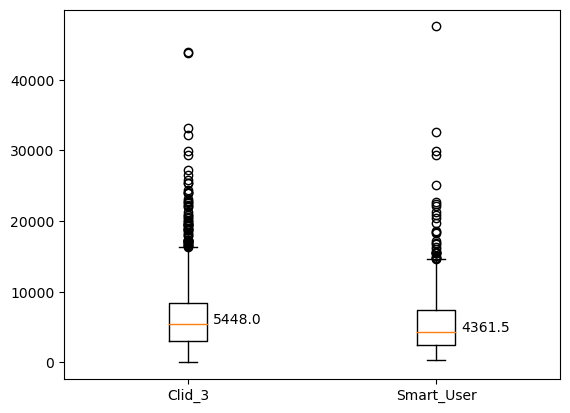

/tmp/ipykernel_3353/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()


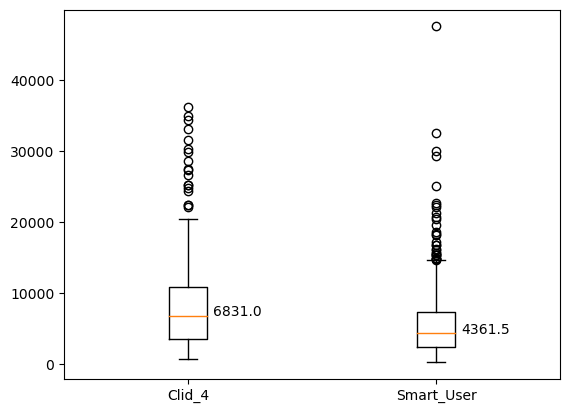

/tmp/ipykernel_3353/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()


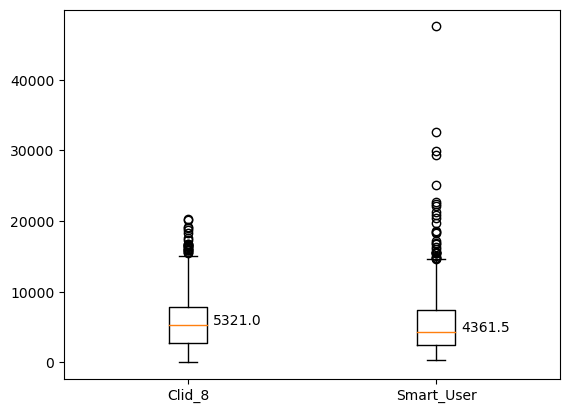

/tmp/ipykernel_3353/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()


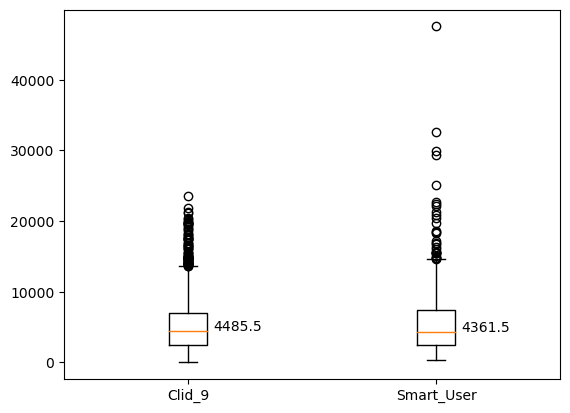

/tmp/ipykernel_3353/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()


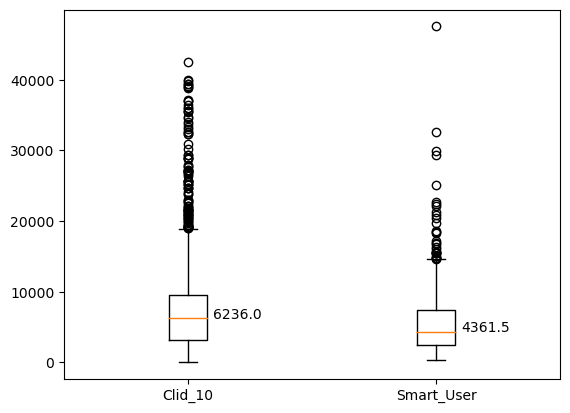

/tmp/ipykernel_3353/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()


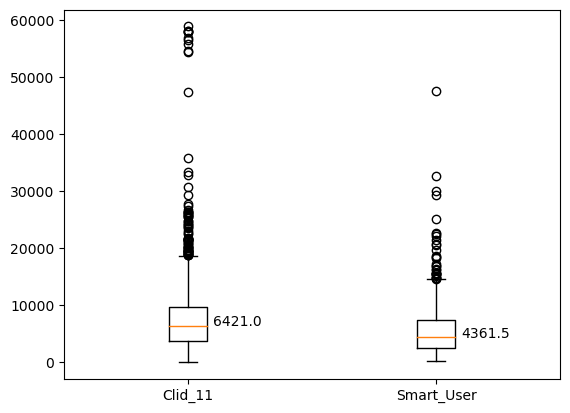

/tmp/ipykernel_3353/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()


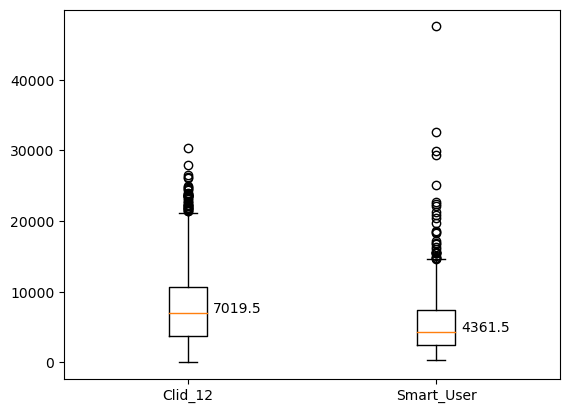

/tmp/ipykernel_3353/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()


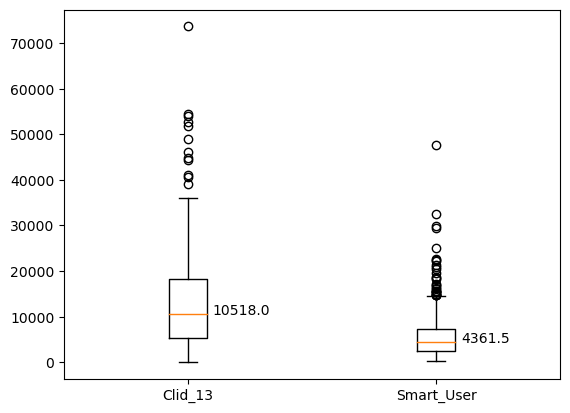

/tmp/ipykernel_3353/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()


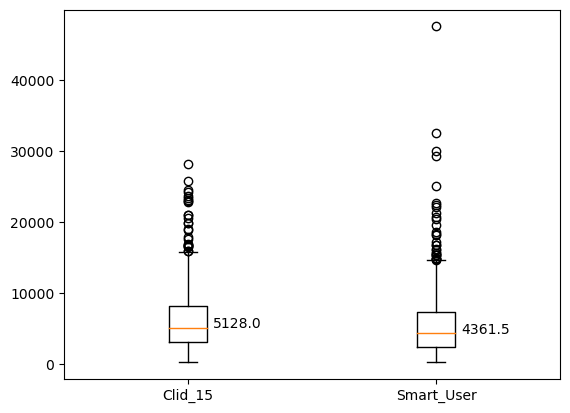

/tmp/ipykernel_3353/631648046.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['device_id_deidentification','date']).sum()


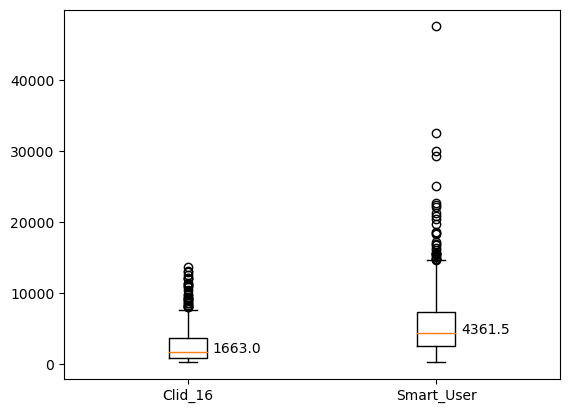

In [46]:
cluster = [2,3,4,8,9,10,11,12,13,15,16]
# 에너지 소모량 비교
for i, c in enumerate(cluster,1):
    compare_smart_boxplot_energysum(c)

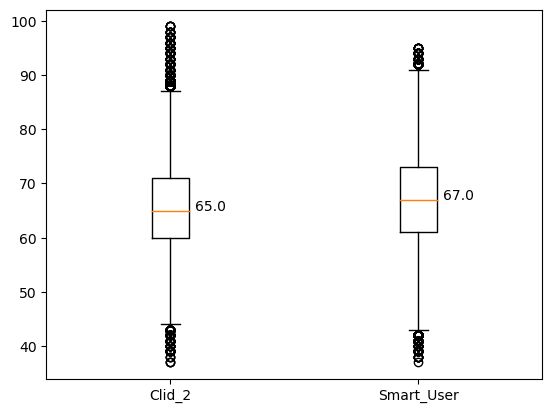

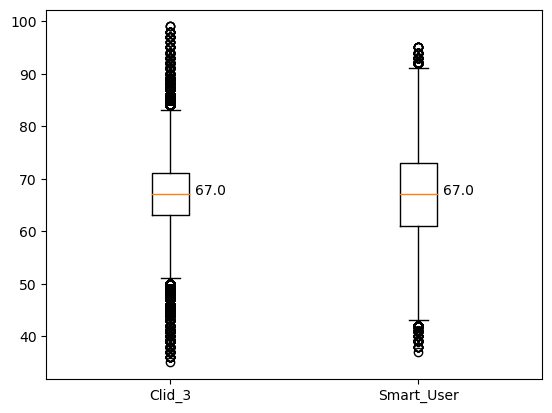

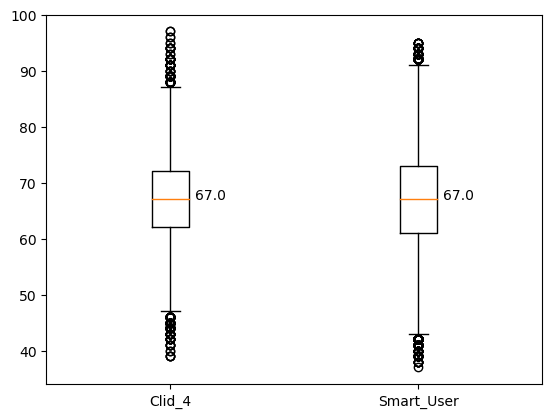

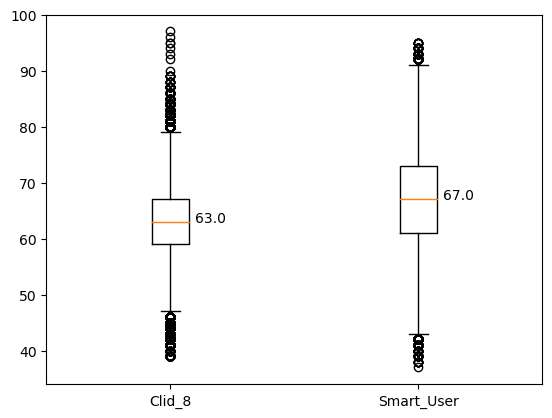

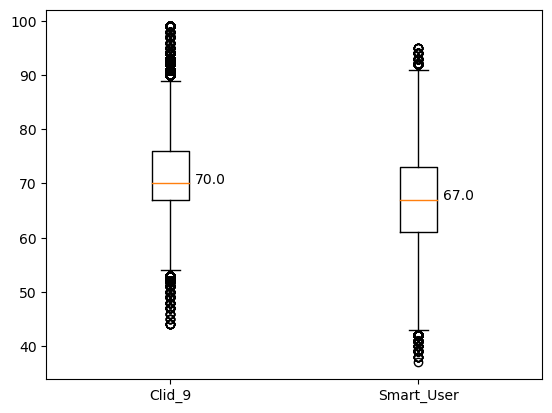

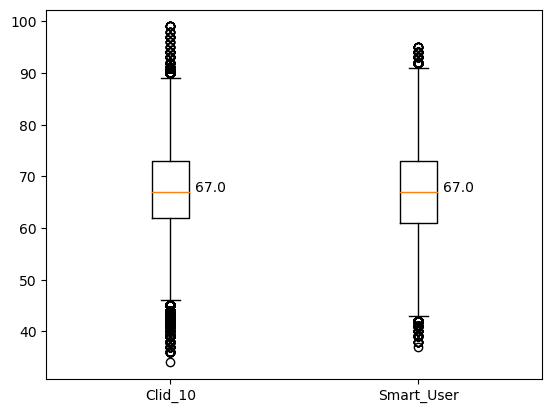

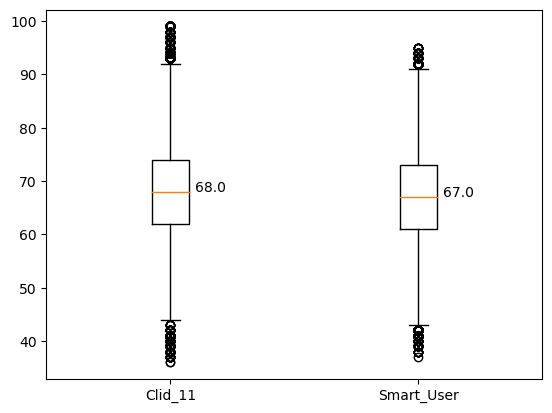

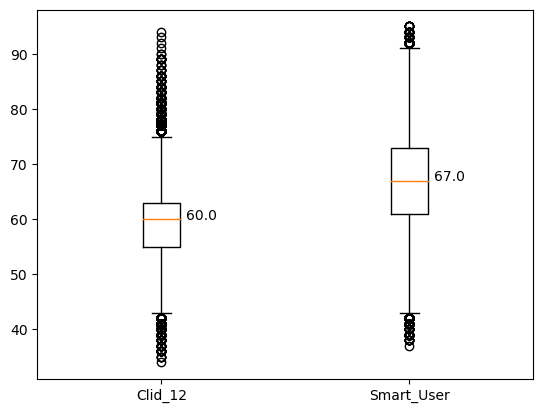

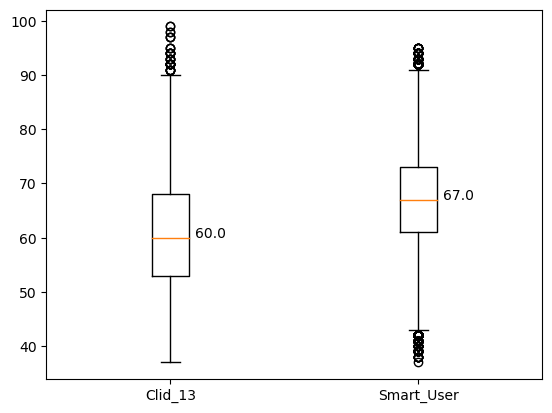

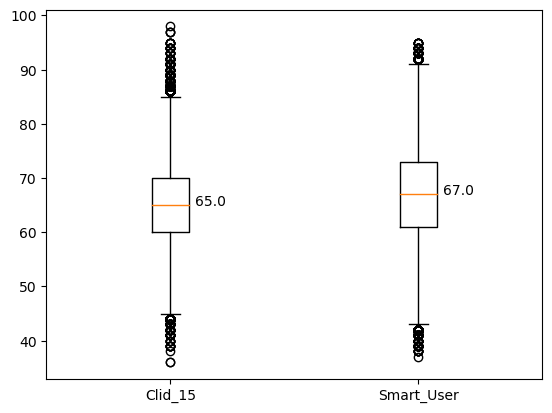

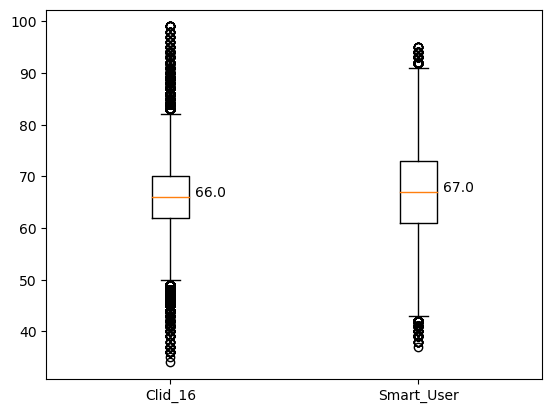

In [47]:
cluster = [2,3,4,8,9,10,11,12,13,15,16]
# 습도 비교
for i, c in enumerate(cluster,1):
    compare_smart_boxplot_humidity(c)

In [48]:
print(smart_dehum_user['humidity'].mean())
print(always_dehum_user['humidity'].mean())
print(not_dehum_user['humidity'].mean())

66.93586772140206
65.9040492303116
67.63903278136094


In [49]:
print(smart_dehum_user_daysum['energywatt'].mean())
print(always_dehum_user_daysum['energywatt'].mean())
print(not_dehum_user_daysum['energywatt'].mean())

5533.835917312662
6793.434312210201
7886.6176683562635


In [50]:
smart_dehum_user['airstate.opmode2'].value_counts()

0    67135
1    51947
Name: airstate.opmode2, dtype: int64

In [51]:
dev_info = smart_dehum_user['device_id_deidentification'].value_counts()

In [52]:
devicedf = smart_dehum_user[smart_dehum_user['device_id_deidentification']==dev_info.index[0]]
devicedf = devicedf.set_index('create_dt')
devicedf

,device_id_deidentification,airstate.opmode,energywatt,humidity,airstate.windstrength,currenttemperature,airstate.tempstate.target,pm1,pm2,pm10,airstate.opmode2,Clid,month,day,hour,minute,weekday,weekend,date,sensory_temp
create_dt,,,,,,,,,,,,,,,,,,,,
2021-07-15 09:18:56,cec0ced650e3fbf6863411f4472309d4019333ec43e875...,1,44,81.0,5,28.0,26.0,0.0,0.0,0.0,0,7,7,15,9,18,목,0,2021-07-15,30.083434
2021-07-15 09:23:57,cec0ced650e3fbf6863411f4472309d4019333ec43e875...,1,0,74.0,5,27.0,26.0,0.0,0.0,0.0,0,7,7,15,9,23,목,0,2021-07-15,28.833194
2021-07-15 09:28:58,cec0ced650e3fbf6863411f4472309d4019333ec43e875...,1,0,72.0,5,27.0,26.0,0.0,0.0,0.0,0,7,7,15,9,28,목,0,2021-07-15,28.833194
2021-07-15 09:33:59,cec0ced650e3fbf6863411f4472309d4019333ec43e875...,1,278,64.0,1,27.0,27.0,0.0,0.0,0.0,0,7,7,15,9,33,목,0,2021-07-15,29.075500
2021-07-15 09:39:00,cec0ced650e3fbf6863411f4472309d4019333ec43e875...,1,0,64.0,1,27.0,27.0,0.0,0.0,0.0,0,7,7,15,9,39,목,0,2021-07-15,29.075500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01 08:38:04,cec0ced650e3fbf6863411f4472309d4019333ec43e875...,0,0,70.0,3,26.0,26.0,0.0,0.0,0.0,1,1,8,1,8,38,일,1,2021-08-01,27.716061
2021-08-01 08:43:05,cec0ced650e3fbf6863411f4472309d4019333ec43e875...,0,75,70.0,3,26.0,26.0,0.0,0.0,0.0,1,1,8,1,8,43,일,1,2021-08-01,27.716061
2021-08-01 08:48:06,cec0ced650e3fbf6863411f4472309d4019333ec43e875...,0,0,70.0,3,26.0,26.0,0.0,0.0,0.0,1,1,8,1,8,48,일,1,2021-08-01,27.716061


In [53]:
import pandas as pd
dd=all_df.set_index('create_dt')
# dd.humidity.resample('H').mean().plot()
df=pd.DataFrame(dd['airstate.windstrength'].resample('D').mean())

In [54]:
always_info=always_dehum_user['device_id_deidentification'].value_counts().index
always_df = []
for device in always_info:
    temp=always_dehum_user.loc[always_dehum_user['device_id_deidentification']==device]
    always_df.append(temp)

In [55]:
df=always_df[0].set_index(['create_dt'])

/tmp/ipykernel_3353/1708065093.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ax1.plot(df['2021-08-01'].resample('H').mean().index,df['2021-08-01'].resample('H').mean()['humidity'])
/tmp/ipykernel_3353/1708065093.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax1.plot(df['2021-08-01'].resample('H').mean().index,df['2021-08-01'].resample('H').mean()['humidity'])
/tmp/ipykernel_3353/1708065093.py:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ax2.scatter(

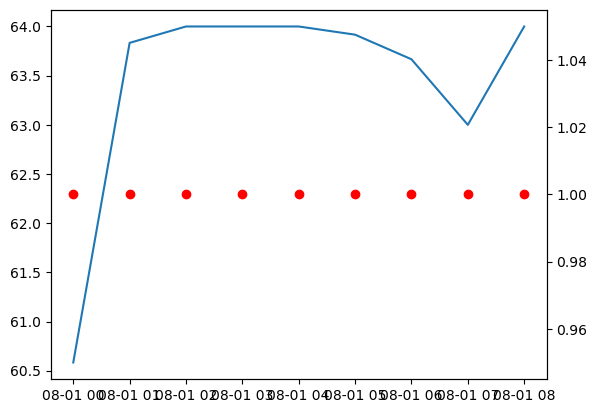

In [56]:
# plt.plot(df['2021-07-04'].resample('H').mean()['humidity'])
fig, ax1 = plt.subplots()
ax1.plot(df['2021-08-01'].resample('H').mean().index,df['2021-08-01'].resample('H').mean()['humidity'])

ax2 = ax1.twinx()
ax2.scatter(df['2021-08-01'].resample('H').last().index,df['2021-08-01'].resample('H').last()['airstate.opmode2'],color='red')
plt.show()

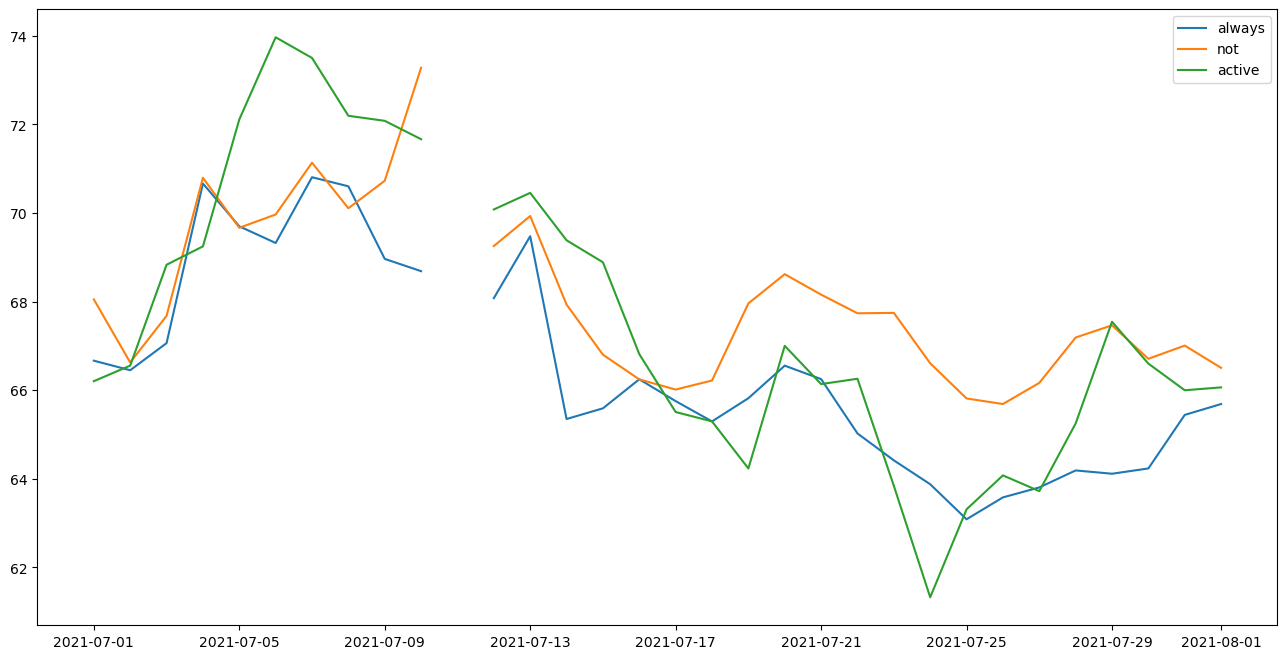

In [57]:
plt.figure(figsize=(16,8))
always_df2 = always_dehum_user.set_index(['create_dt'])
plt.plot(always_df2.resample('D')['humidity'].mean(),label = 'always')
not_df2 = not_dehum_user.set_index(['create_dt'])
plt.plot(not_df2.resample('D')['humidity'].mean(),label='not')
smart_df2 = smart_dehum_user.set_index(['create_dt'])
plt.plot(smart_df2.resample('D')['humidity'].mean(),label='active')
plt.legend()
plt.show()

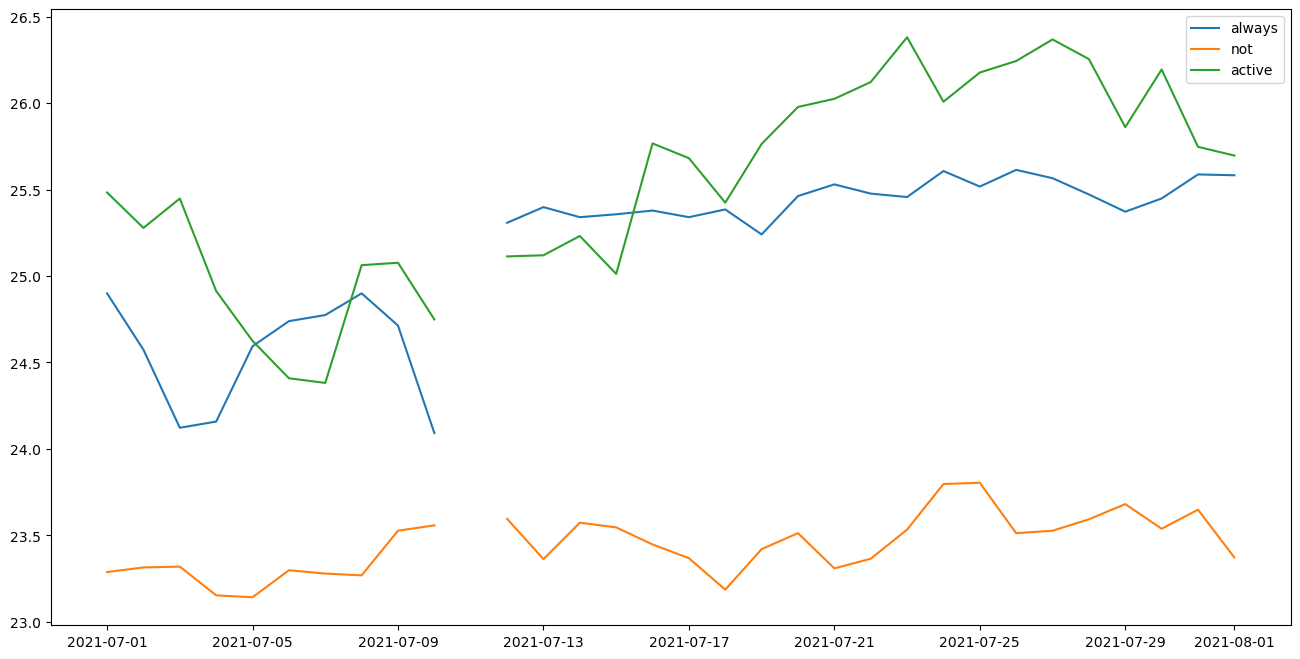

In [58]:
plt.figure(figsize=(16,8))
always_df2 = always_dehum_user.set_index(['create_dt'])
plt.plot(always_df2.resample('D')['currenttemperature'].mean(),label = 'always')
not_df2 = not_dehum_user.set_index(['create_dt'])
plt.plot(not_df2.resample('D')['currenttemperature'].mean(),label='not')
smart_df2 = smart_dehum_user.set_index(['create_dt'])
plt.plot(smart_df2.resample('D')['currenttemperature'].mean(),label='active')
plt.legend()
plt.show()

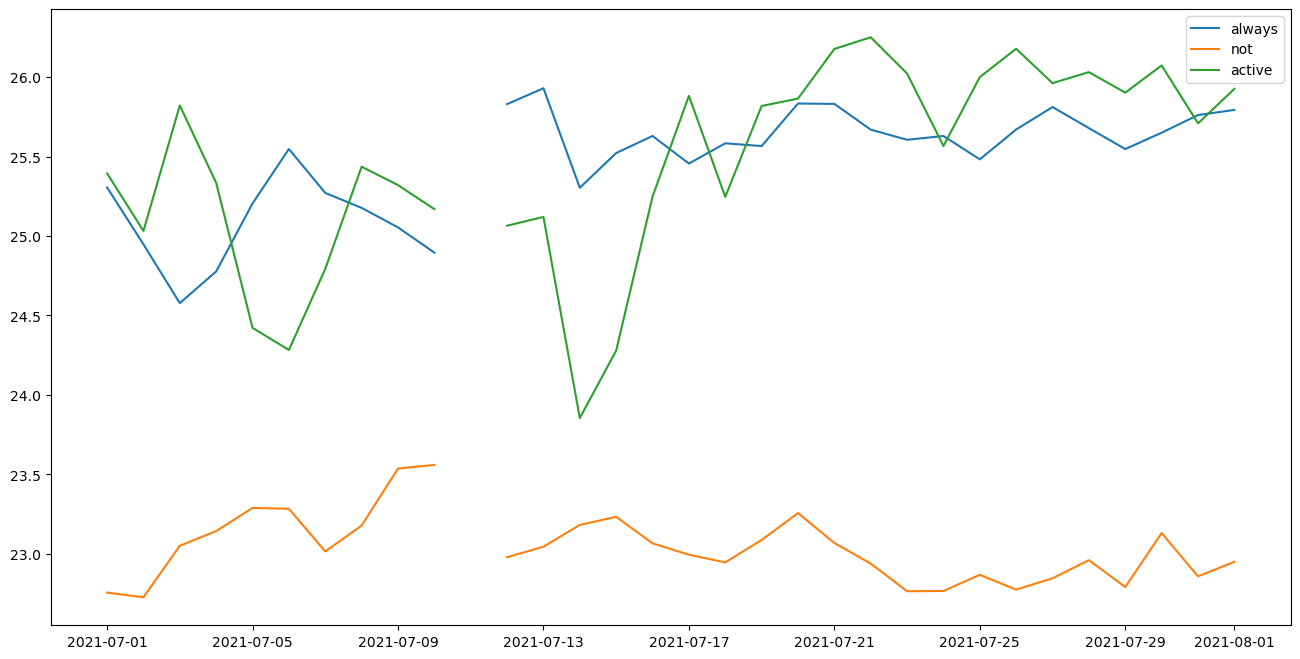

In [59]:
plt.figure(figsize=(16,8))
always_df2 = always_dehum_user.set_index(['create_dt'])
plt.plot(always_df2.resample('D')['airstate.tempstate.target'].mean(),label = 'always')
not_df2 = not_dehum_user.set_index(['create_dt'])
plt.plot(not_df2.resample('D')['airstate.tempstate.target'].mean(),label='not')
smart_df2 = smart_dehum_user.set_index(['create_dt'])
plt.plot(smart_df2.resample('D')['airstate.tempstate.target'].mean(),label='active')
plt.legend()
plt.show()

/tmp/ipykernel_3353/1608918895.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample('H').mean()


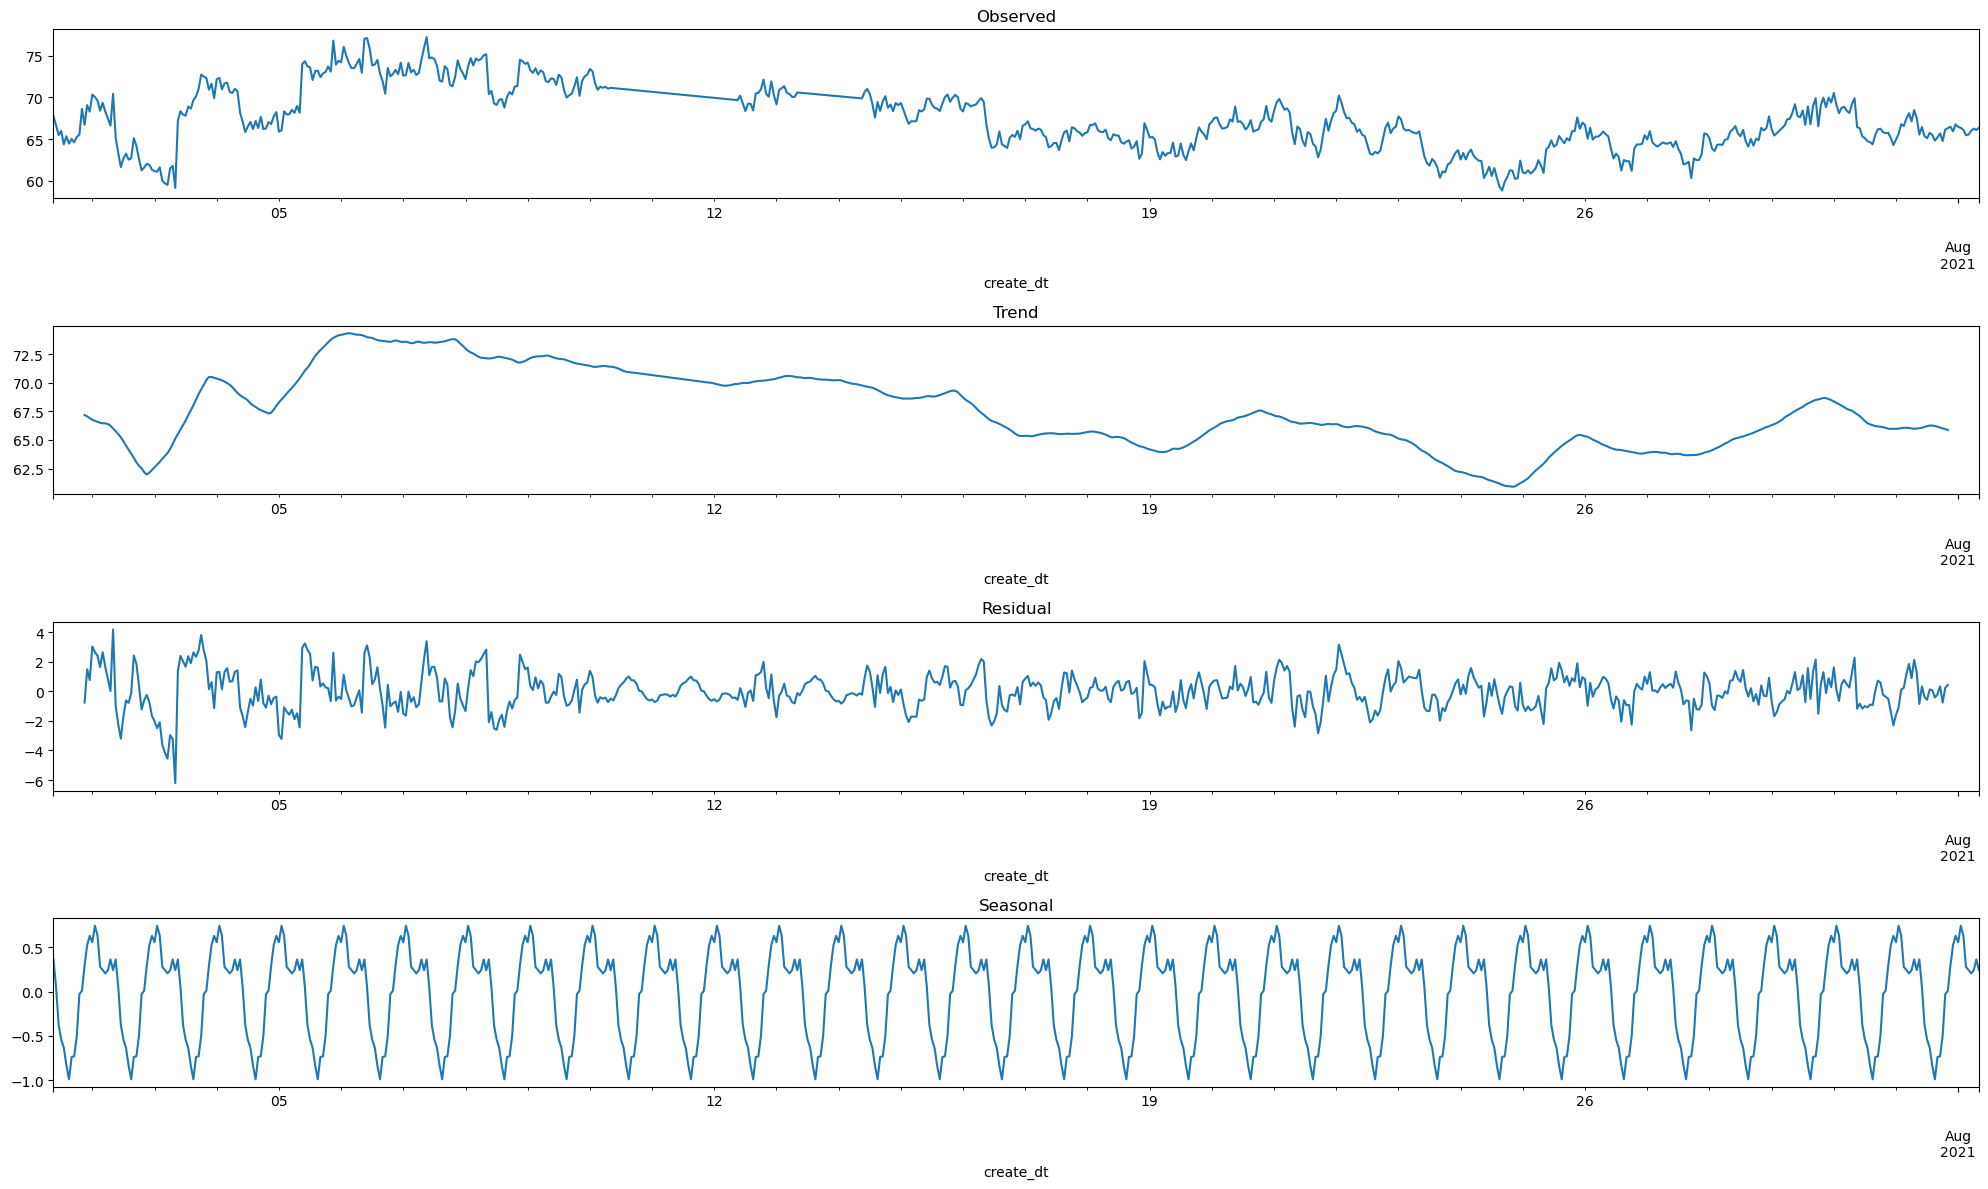

In [60]:
vis_time_series_decompose(smart_dehum_user,'humidity')

/tmp/ipykernel_3353/1608918895.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample('H').mean()


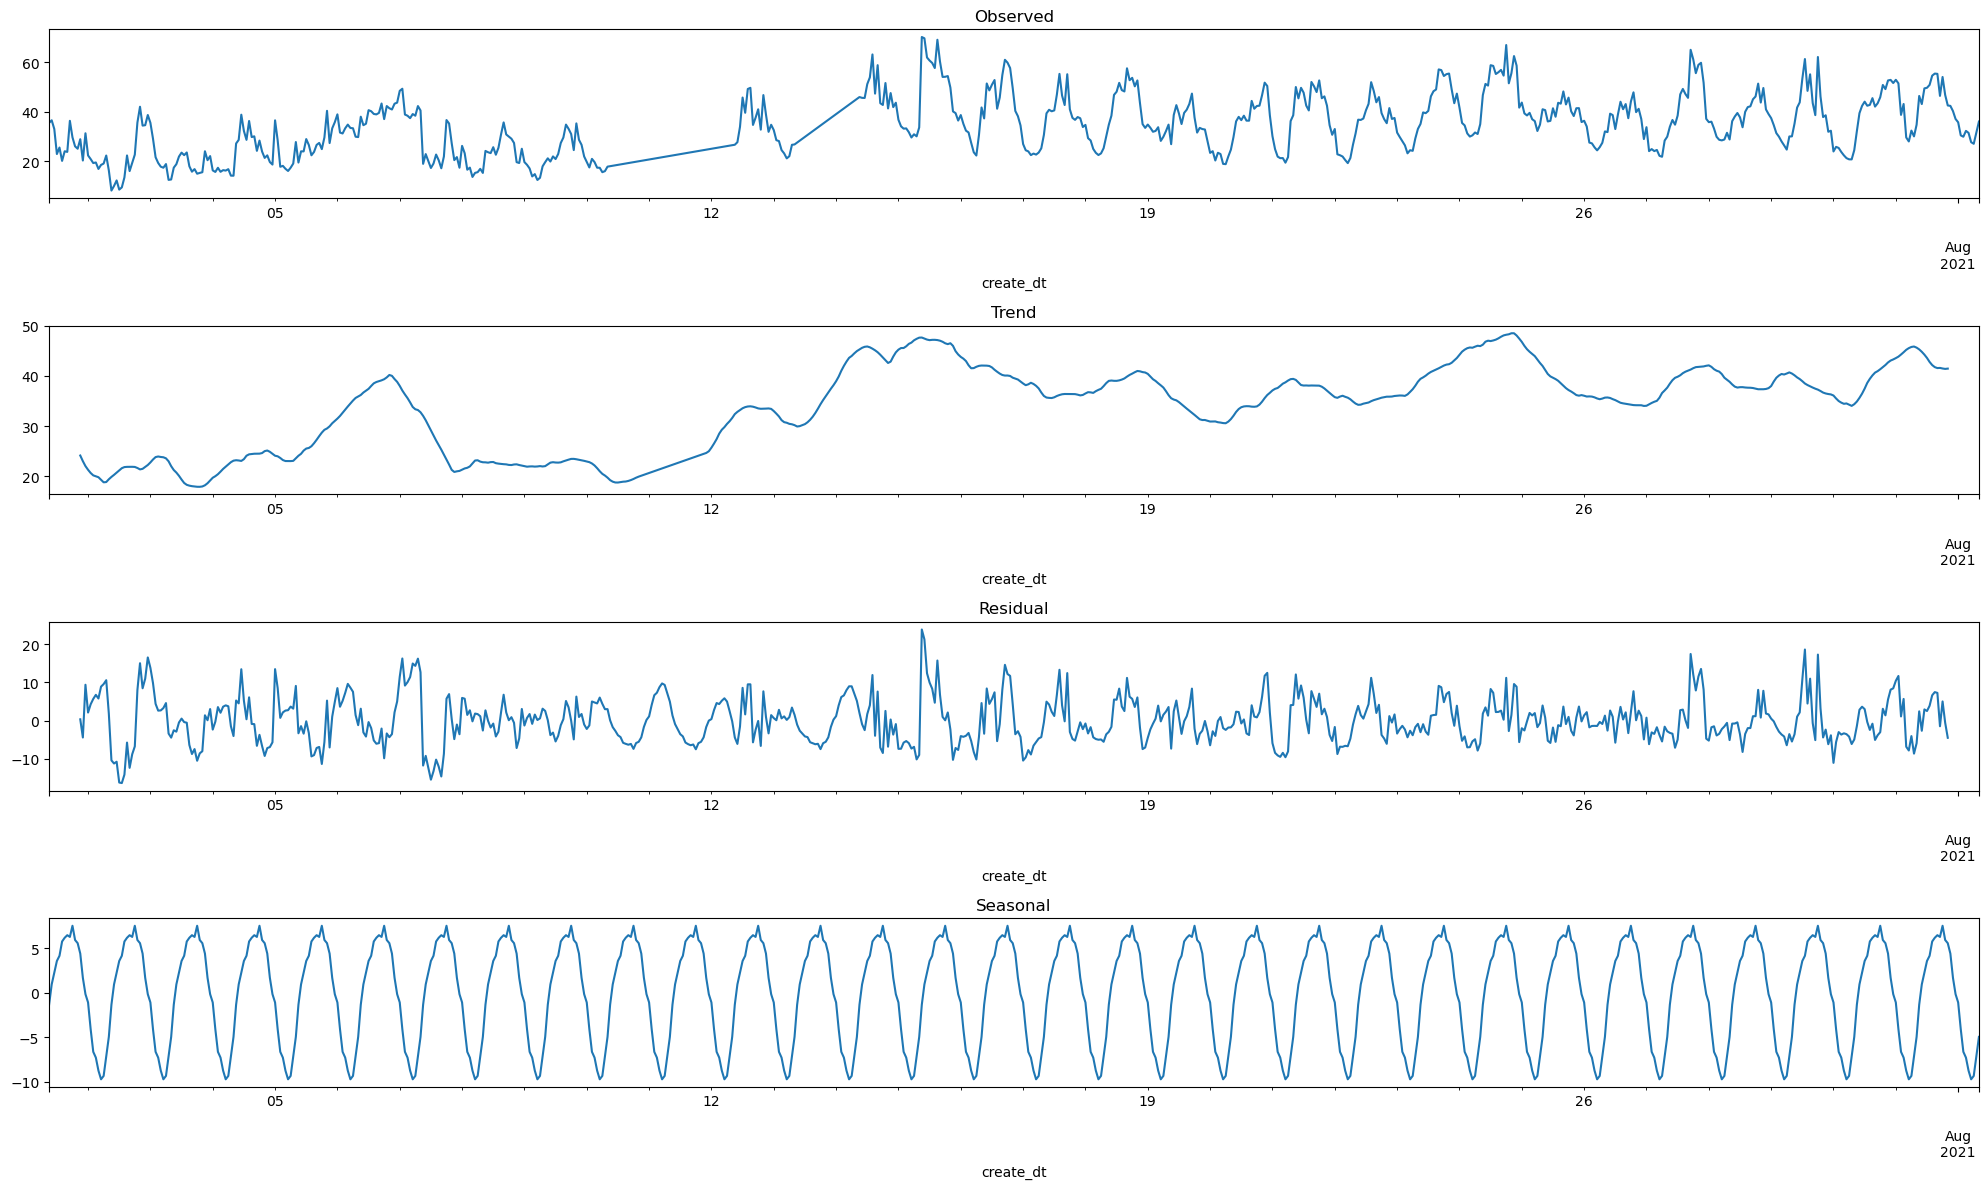

In [61]:
vis_time_series_decompose(smart_dehum_user,'energywatt')

결정트리 모델 - 제습모드 on/off 분류모델

In [73]:
# 전처리
df = smart_dehum_user.set_index(['create_dt'])
df1 = df[['humidity','currenttemperature', 
          'airstate.tempstate.target', 'pm1', 'pm2', 'pm10','sensory_temp']]
df2 = df[['airstate.opmode', 'airstate.windstrength',
       'airstate.opmode2','day', 'hour', 'weekend']]
df3 = df['energywatt']
df1 = df1.resample('H').mean()
df2 = df2.resample('H').first()
df3 = df3.resample('H').sum()
df1 = df1.interpolate(method='time')
df2 = df2.interpolate(method='nearest')
df3 = df3.interpolate(method='time')
df2 = df2.astype('int')
df = pd.concat([df1,df2,df3],axis=1)

/home/deallab/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


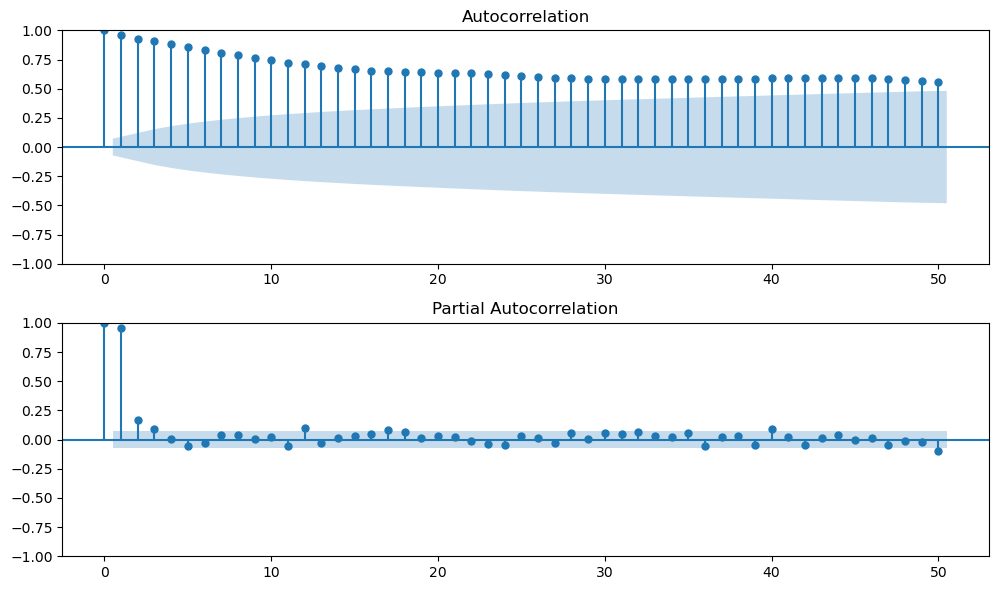

In [77]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df['humidity'], lags=50, ax=ax1)
plot_pacf(df['humidity'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

In [53]:
# 한시간 전 
cols= ['humidity', 'currenttemperature',
       'airstate.tempstate.target', 'pm1', 'pm2', 'pm10', 'sensory_temp',
       'airstate.opmode', 'airstate.windstrength', 'airstate.opmode2']
# 한시간 전 데이터를 변수로 추가
for col in cols:
    df[f"prior_{col}"] = df[col].shift(1)
    df[f"diff_{col}"] = df[col] - df[col].shift(1)

df = df.iloc[1:,:]
cols = ['prior_airstate.windstrength','prior_airstate.opmode2','diff_airstate.windstrength'] # 범주형 변수 타입 변경
df = df.drop(['diff_airstate.opmode','diff_airstate.opmode2','day','energywatt','prior_airstate.opmode'],axis=1) # 필요없는 변수 제거
# energywatt같은 경우 USER가 기기 조작시에 알 수 없는 데이터이므로 모델에서 제거
# 차이변수 생성
df = df.drop(['airstate.windstrength','airstate.tempstate.target'], axis = 1) # diff 변수에 영향이 들어가므로 제거
for col in cols:
    df[col] = df[col].astype('int')

In [55]:
# 제습모드 분류를 위한 X,y 설정
X = df.loc[:,df.columns.difference(['airstate.opmode2','airstate.opmode'])]
y = df.loc[:,'airstate.opmode2']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [56]:
# 그리드 서치 해야함
DT = DecisionTreeClassifier(random_state=42)
tree_model=DT.fit(X_train,y_train)
y_pred = DT.predict(X_test)

print(accuracy_score(y_test,y_pred))

0.7443946188340808


In [57]:
param_grid = {'max_depth' : range(4,24,2),'min_samples_split' : range(5,20,1)}
gs = GridSearchCV(DT,param_grid = param_grid, scoring='accuracy',cv = 3, n_jobs=-1,verbose=2)
gs.fit(X_train,y_train)
print(gs.best_params_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
{'max_depth': 6, 'min_samples_split': 9}


In [58]:
# gs.score(X_train,y_train)
gs.score(X_test,y_test)
DT = DecisionTreeClassifier(max_depth=  6, min_samples_split=9,random_state=42)
tree_model=DT.fit(X_train,y_train)

In [59]:
DT.score(X_train,y_train)
DT.score(X_test,y_test)

0.7757847533632287

In [60]:
from sklearn import tree
fig = plt.figure(figsize=(20, 10),dpi=800)
tree.plot_tree(tree_model,class_names=['0','1'],feature_names=X.columns.to_list())

plt.show()

In [61]:
## Text Representation
model_text = tree.export_text(tree_model,feature_names=X.columns.to_list())

print(model_text)

|--- prior_airstate.opmode2 <= 0.50
|   |--- diff_airstate.windstrength <= -0.50
|   |   |--- prior_airstate.tempstate.target <= 26.26
|   |   |   |--- currenttemperature <= 25.97
|   |   |   |   |--- prior_currenttemperature <= 25.44
|   |   |   |   |   |--- prior_pm10 <= 0.66
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- prior_pm10 >  0.66
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- prior_currenttemperature >  25.44
|   |   |   |   |   |--- diff_airstate.tempstate.target <= 0.09
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- diff_airstate.tempstate.target >  0.09
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- currenttemperature >  25.97
|   |   |   |   |--- humidity <= 62.30
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- humidity >  62.30
|   |   |   |   |   |--- class: 0
|   |   |--- prior_airstate.tempstate.target >  26.26
|   |   |   |--- class: 1
|   |--- diff_airstate.windstrength >  -0.50
|   |   |--- prior_sensory

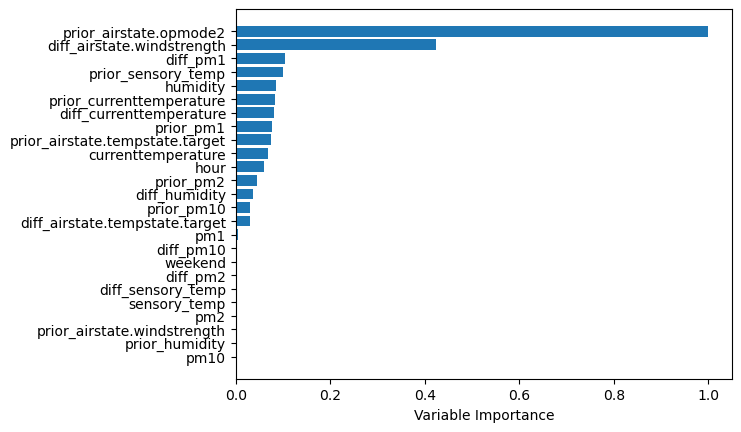

In [62]:
names = X.columns
featureImportance = DT.feature_importances_

#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, names[sorted_idx])
plt.xlabel('Variable Importance')
plt.show()

In [63]:
rf = RandomForestClassifier(random_state=42)
# 그리드 서치
param_grid = [{'n_estimators':[100],'max_features':range(1,10),'max_depth':range(6,12,2)}]
gs = GridSearchCV(rf,param_grid = param_grid, scoring='accuracy',cv = 3, n_jobs=-1,verbose=2)
gs.fit(X_train,y_train)
print(gs.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'max_depth': 6, 'max_features': 7, 'n_estimators': 100}


In [64]:
print('random forest parameter : ',gs.best_params_) # 최적 파라미터
rf = RandomForestClassifier(max_depth=6, max_features=7, n_estimators=100,random_state=42)
rf_model=rf.fit(X_train,y_train)

random forest parameter :  {'max_depth': 6, 'max_features': 7, 'n_estimators': 100}


In [65]:
y_pred = rf_model.predict(X_test)

print(accuracy_score(y_test,y_pred))

0.7937219730941704


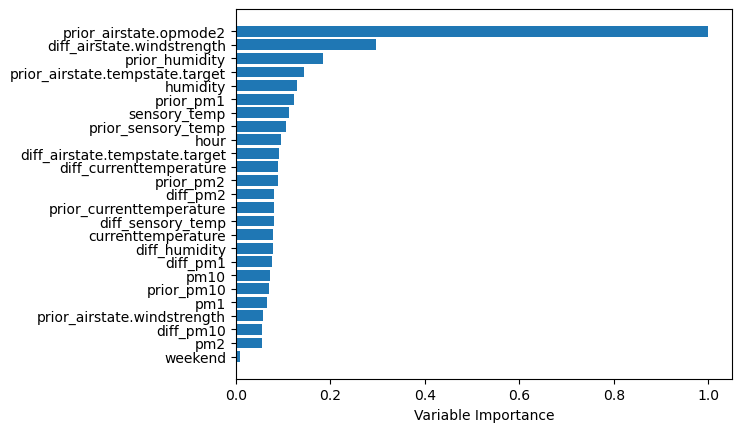

In [66]:
names = X.columns
featureImportance = rf.feature_importances_

#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, names[sorted_idx])
plt.xlabel('Variable Importance')
plt.show()

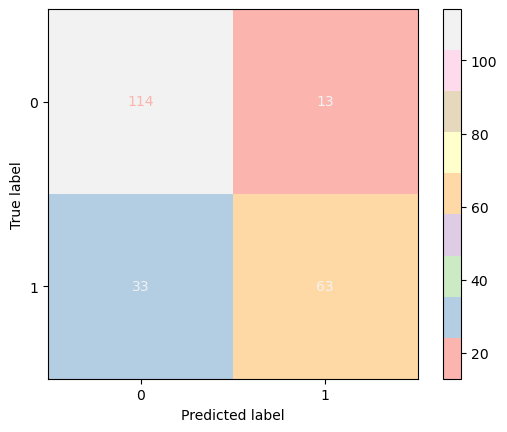

In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
plot_confusion_matrix(rf, X_test, y_test,
                         include_values = True,
                         display_labels = ['0', '1'], # 목표변수 이름
                         cmap = 'Pastel1') # 컬러맵

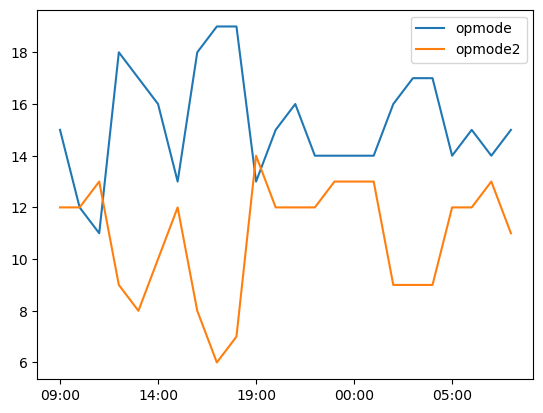

In [68]:
dd=smart_dehum_user.set_index('create_dt')
dd=pd.DataFrame(dd.resample('H').first())
row=['09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00',
     '18:00','19:00','20:00','21:00','22:00','23:00','00:00','01:00','02:00','03:00',
     '04:00','05:00','06:00','07:00','08:00']
dd_smart=pd.DataFrame(columns=['opmode','opmode2'],index=row)

for i in range(24):
    dd_smart.iloc[i,0] = int(dd.iloc[i::24,1].sum())
    dd_smart.iloc[i,1] = int(dd.iloc[i::24,10].sum())
dd_smart['opmode'].plot()
dd_smart['opmode2'].plot()
plt.legend()
plt.show()

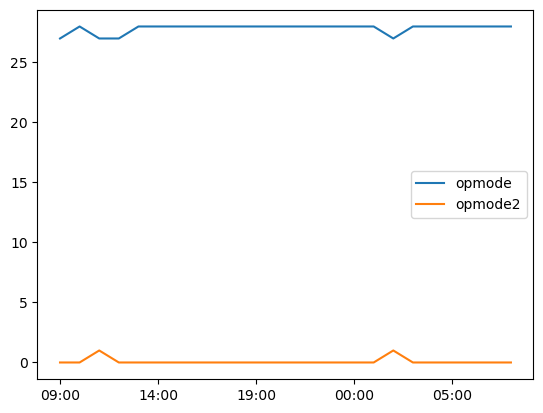

In [62]:
# not active user에 가깝다
dd=not_dehum_user.set_index('create_dt')
dd=pd.DataFrame(dd.resample('H').first())
row=['09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00',
     '18:00','19:00','20:00','21:00','22:00','23:00','00:00','01:00','02:00','03:00',
     '04:00','05:00','06:00','07:00','08:00']
dd_smart=pd.DataFrame(columns=['opmode','opmode2'],index=row)

for i in range(24):
    dd_smart.iloc[i,0] = int(dd.iloc[i::24,1].sum())
    dd_smart.iloc[i,1] = int(dd.iloc[i::24,10].sum())
dd_smart['opmode'].plot()
dd_smart['opmode2'].plot()
plt.legend()
plt.show()

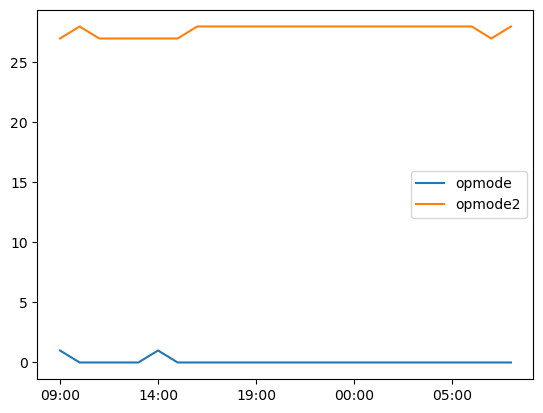

In [63]:
dd=always_dehum_user.set_index('create_dt')
dd=pd.DataFrame(dd.resample('H').first())
row=['09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00',
     '18:00','19:00','20:00','21:00','22:00','23:00','00:00','01:00','02:00','03:00',
     '04:00','05:00','06:00','07:00','08:00']
dd_smart=pd.DataFrame(columns=['opmode','opmode2'],index=row)

for i in range(24):
    dd_smart.iloc[i,0] = int(dd.iloc[i::24,1].sum())
    dd_smart.iloc[i,1] = int(dd.iloc[i::24,10].sum())
dd_smart['opmode'].plot()
dd_smart['opmode2'].plot()
plt.legend()
plt.show()

In [71]:
not_dehum_user.columns

Index(['device_id_deidentification', 'create_dt', 'airstate.opmode',
       'energywatt', 'humidity', 'airstate.windstrength', 'currenttemperature',
       'airstate.tempstate.target', 'pm1', 'pm2', 'pm10', 'airstate.opmode2',
       'Clid', 'month', 'day', 'hour', 'minute', 'weekday', 'weekend', 'date',
       'sensory_temp'],
      dtype='object')